### Import des librairies / packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests

# Set Seaborn style
sns.set(style="whitegrid")

### Download and Read the data

In [2]:
def read_data_from_url(url):
    response = requests.get(url)
    return pd.read_csv(StringIO(response.text), header=None, delimiter="\s+")


def rename_columns(df, new_column_names):
    df.rename(columns=new_column_names, inplace=True)


def melt_dataframe(df, name):
    melted_df = pd.melt(df, var_name="COLUMN", value_name=name)
    melted_df.drop(columns=["COLUMN"], inplace=True)
    melted_df.reset_index(drop=True, inplace=True)
    return melted_df


def process_appart_data(url_x, url_appart):
    df_x = read_data_from_url(url_x)
    df_appart = read_data_from_url(url_appart)

    column_rename_mapping = {0: "APPART"}
    rename_columns(df_appart, column_rename_mapping)

    merged_df = pd.concat([df_appart, df_x], axis=1)

    appartements_dataframes = {}

    for appart_id in range(1, 101):  # The is 100 appartements in total
        filtered_appartments = merged_df.query("APPART == @appart_id").transpose()[1:]

        column_mapping = {
            old_column: f"JOUR_{old_column}"
            for old_column in filtered_appartments.columns
        }
        filtered_appartments.rename(columns=column_mapping, inplace=True)

        appartements_dataframes[f"appartement_{appart_id}"] = melt_dataframe(
            filtered_appartments, f"appartement_{appart_id}"
        )

    result_df = pd.concat(appartements_dataframes.values(), axis=1)

    time_column = pd.date_range(start="1/1/2023", periods=len(result_df), freq="30min")
    result_df = pd.concat(
        [pd.DataFrame(time_column, columns=["Time"]), result_df], axis=1
    )

    return result_df


# URLs for the data
url_x = "http://allousame.free.fr/mlds/donnees/X.txt"
url_appart = "http://allousame.free.fr/mlds/donnees/APPART.txt"

# Process data and get the result DataFrame
appartements = process_appart_data(url_x, url_appart)

## Data Exploration 

In [3]:
appartements.head(3)

,Time,appartement_1,appartement_2,appartement_3,appartement_4,appartement_5,appartement_6,appartement_7,appartement_8,appartement_9,...,appartement_91,appartement_92,appartement_93,appartement_94,appartement_95,appartement_96,appartement_97,appartement_98,appartement_99,appartement_100
0,2023-01-01 00:00:00,-1.786785,-1.696926,0.152293,-0.951338,-1.117863,-0.619164,-1.934051,-1.231540,-0.915803,...,-1.458296,-0.943808,-1.058543,0.094067,-0.551474,-1.476726,-0.147306,-1.459160,-1.636396,-0.587143
1,2023-01-01 00:30:00,-1.759306,-1.589682,-0.001868,-1.038791,-1.209420,-0.809750,-1.509850,-1.642594,-0.966073,...,-1.435501,-1.081751,-1.189145,-0.598292,-0.770247,-1.384780,-0.628073,-1.487654,-1.735798,-0.958683
2,2023-01-01 01:00:00,-1.731826,-1.482438,-0.156029,-1.126245,-1.300976,-1.000337,-1.085648,-2.053648,-1.016343,...,-1.412706,-1.219694,-1.319748,-1.290650,-0.989019,-1.292834,-1.108839,-1.516149,-1.835200,-1.330222


### Energy Consumption: Apartment 1 over the time

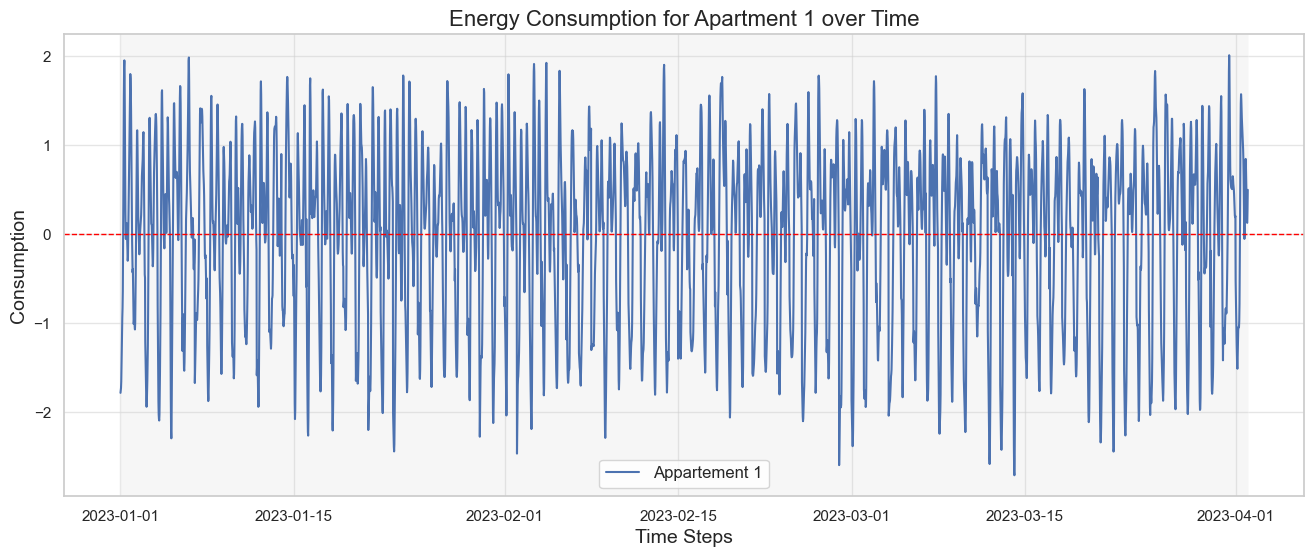

In [4]:
# Create a line plot using Seaborn
plt.figure(figsize=(16, 6))

# Plot the data with enhanced aesthetics
sns.lineplot(
    data=appartements,
    x="Time",
    y="appartement_1",
    color="b",
    linestyle="-",
    label="Appartement 1",
)

# Add labels and title with increased font size
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Consumption", fontsize=14)
plt.title("Energy Consumption for Apartment 1 over Time", fontsize=16)

# Add grid for better readability
plt.grid(True, alpha=0.5)

# Add legend for clarity with increased font size
plt.legend(fontsize=12)

# Add a horizontal line at zero for reference
plt.axhline(y=0, color="red", linestyle="--", linewidth=1)

# Adding a light background color
plt.axvspan(
    appartements["Time"].min(),
    appartements["Time"].max(),
    facecolor="lightgray",
    alpha=0.2,
)

# Show the plot
plt.show()

### Aggregation mensuel et journalière des données
Nous ne voulons pour l'instant faire qu'une visualisation sommaire afin de mieux comprendre nos données, nous allons donc agréger les consommations **par mois** et **par semaine** et par **jour**

In [5]:
# Aggregation mensuel des données pour appartements
df_monthly = appartements.copy()
df_monthly["Month"] = df_monthly["Time"].dt.month
df_monthly = df_monthly.drop(columns=["Time"]).groupby("Month").sum()

# Aggregation journalière des données pour appartements
df_daily = appartements.copy()
df_daily["Day"] = df_daily["Time"].dt.strftime("%Y-%m-%d")
df_daily = df_daily.drop(columns=["Time"]).groupby(["Day"]).sum().reset_index()

# Aggregation hebdomadaire des données pour appartements
df_weekly = appartements.copy()
df_weekly["Week"] = df_weekly["Time"].dt.strftime(
    "%Y-%U"
)  # Formatage de la date pour extraire la semaine
df_weekly = df_weekly.drop(columns=["Time"]).groupby(["Week"]).sum().reset_index()

### Graphique à barres pour la consommation totale par jour

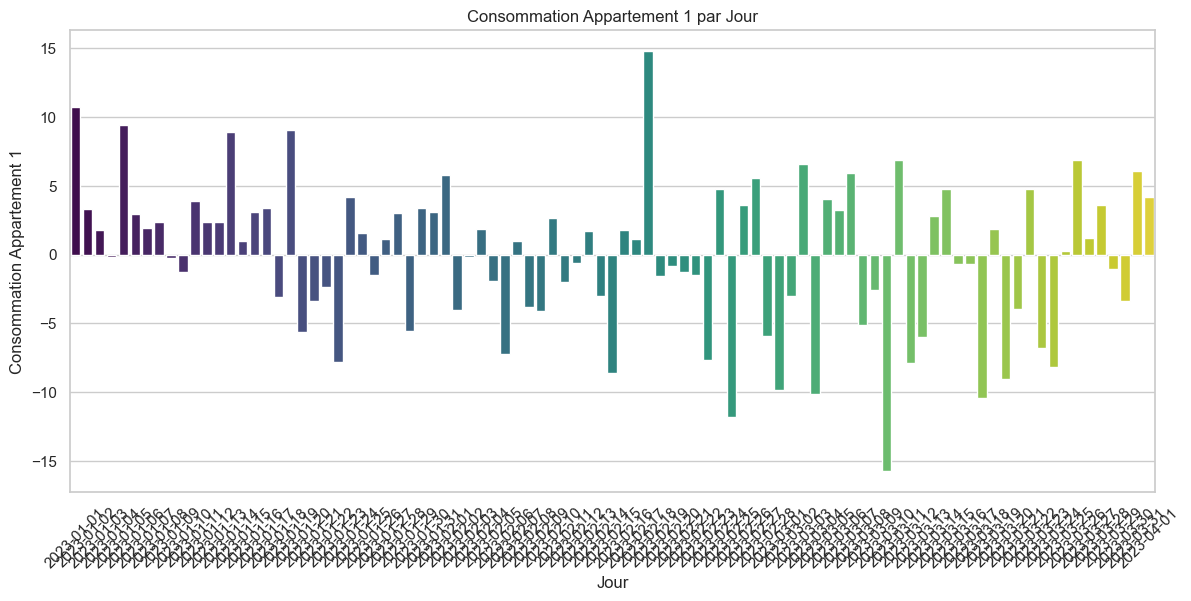

In [6]:
plt.figure(figsize=(14, 6))
sns.barplot(
    x="Day", y="appartement_1", data=df_daily, hue="Day", palette="viridis", dodge=False
)
plt.xlabel("Jour")
plt.ylabel("Consommation Appartement 1")
plt.title("Consommation Appartement 1 par Jour")
plt.xticks(rotation=45)
plt.show()